# Messy Notebook

Most of the data was downloaded in CSV form from different websites.  The inflation data needed to be obatined from a spreadsheet. Getting Inflation Data:

In [299]:
import pandas as pd
import scipy.stats as stats
dat = pd.read_html("https://www.usinflationcalculator.com/inflation/historical-inflation-rates/")
df = pd.DataFrame(dat[0])
df = df.set_index("Year")
df.to_csv('data/inflation.csv', index=True)

### The Following are the Steps Taken to Clean and Merge the Data:

The dow index data is retrieved from two csv files and an online source: https://www.macrotrends.net/1319/dow-jones-100-year-historical-chart for two of the years.  The data is eliminated so only years from 1953 to 2019 remain.  Additionally, only quarterly data will be kept.

In [300]:
dow1 = pd.DataFrame(pd.read_csv('data/dow1.csv'))
dow2 = pd.DataFrame(pd.read_csv('data/dow2.csv'))
dow2.columns

Index(['Date', ' Open', ' High', ' Low', ' Close'], dtype='object')

In [301]:
dow2 = dow2.drop(columns = [' Open', ' High', ' Low'])
dow1 = dow1.drop(list(range(457)))
dow1 = dow1.set_index('DATE')
dow1.columns = ['Close']
dow2 = dow2.drop([12698])
dow2 = dow2.drop(list(range(339)))
dow2 = dow2.iloc[::-1]
dow2.index = list(range(len(dow2)))
dow2['Date'] = pd.to_datetime(dow2['Date'])
toKeep = []
comp = dow2.iloc[0]['Date'].day
for i in range(len(dow2)):
    ind = dow2.iloc[i]['Date'].day
    if(ind <= comp):
        toKeep = toKeep + [i]
    comp = ind
toDrop = []
for i in range(len(dow2)):
    if i not in toKeep:
        toDrop = toDrop + [i]
dow2 = dow2.drop(toDrop)
dow2.index = list(range(len(dow2)))
dow1 = dow1.reset_index()
dow1['DATE'] = pd.to_datetime(dow1['DATE'])
months = [1, 4, 7, 10]
toDrop = []
for i in range(len(dow1)):
    if(dow1.iloc[i]['DATE'].month not in months):
        toDrop = toDrop + [i]
dow1 = dow1.drop(toDrop)
dow1.index = list(range(len(dow1)))
dow1.columns = ['Date', 'Close']
toDrop = []
for i in range(len(dow2)):
    if(dow2.iloc[i]['Date'].month not in months):
        toDrop = toDrop + [i]
dow2 = dow2.drop(toDrop)
dow2.index = list(range(len(dow2)))

The data for 1969 and 1970 is manually gathered from the source.

In [302]:
dow3 = pd.DataFrame(data= {'Date': ['1/1/1969', '4/1/1969', '7/1/1969', '10/1/1969', '1/1/1970', '4/1/1970', '7/1/1970', '10/1/1970'], 'Close': [946.05, 950.18, 815.47, 855.99, 744.06, 736.07, 734.12, 755.61]})
dow3['Date'] = pd.to_datetime(dow3['Date'])
dow1 = dow1.set_index('Date')
dow2 = dow2.set_index('Date')
dow3 = dow3.set_index('Date')
dow2.columns = ['Close']
dow = pd.concat([dow1, dow3, dow2])
dow = dow.reset_index()
dow = dow.drop([0, 1, 2, 3])
dow = dow.drop(columns = ['Date'])
dow.index = list(range(len(dow)))
dow.columns = ['Value of Dow']

In [303]:
dow

,Value of Dow
0,286.64
1,310.92
2,341.27
3,358.29
4,398.43
...,...
259,26651.21
260,23346.24
261,26258.42
262,26717.43


In [304]:
gdp = pd.DataFrame(pd.read_csv('data/gdp.csv'))
gdp.columns = ['Date', 'GDP Growth']
gdp = gdp.drop(list(range(23)))
gdp['Date'] = pd.to_datetime(gdp['Date'])
gdp.index = range(len(gdp))
gdp = gdp.drop([0, 1, 2, 3, 268, 269, 270, 271, 272])
gdp.index = range(len(gdp))

In [305]:
gdp

,Date,GDP Growth
0,1954-01-01,-1.9
1,1954-04-01,0.4
2,1954-07-01,4.6
3,1954-10-01,8.1
4,1955-01-01,11.9
...,...,...
259,2018-10-01,1.3
260,2019-01-01,2.9
261,2019-04-01,1.5
262,2019-07-01,2.6


In [306]:
inf = pd.DataFrame(pd.read_csv('data/inflation.csv'))
inf = inf.drop([106, 107])
inf = inf.drop(list(range(40)))
inf.index = list(range(len(inf)))
vals = []
for i in range(len(inf)):
    vals = vals + [inf.iloc[i]['Jan']] + [inf.iloc[i]['Apr']] + [inf.iloc[i]['Jul']] + [inf.iloc[i]['Oct']]
inf = pd.DataFrame(data = {'Inflation Rate': vals})

In [307]:
inf

,Inflation Rate
0,1.1
1,0.8
2,0.4
3,-0.7
4,-0.7
...,...
259,2.5
260,1.6
261,2.0
262,1.8


In [308]:
unem = pd.DataFrame(pd.read_csv('data/unemployment.csv'))
unem = unem.drop(list(range(72)))
unem = unem.drop(list(range(864, 879)))
unem.index = list(range(len(unem)))
toDrop = []
for i in range(len(unem)):
    if(i % 3):
        toDrop = toDrop + [i]
unem = unem.drop(toDrop)
unem.index = list(range(len(unem)))
unem = unem.drop(columns = ['Series ID', 'Year', 'Period', 'Label', '1-Month Net Change'])
unem.columns = ['Unemployment Rate']

In [309]:
unem

,Unemployment Rate
0,4.9
1,5.9
2,5.8
3,5.7
4,4.9
...,...
259,3.8
260,4.0
261,3.7
262,3.6


In [310]:
#Function takes yearly data and will fill in missing data using a linear model
#For year1 data and year2 data:
#July is average of the data of year1 and year2
#April is average of July and year1 data
#October is average of July and year2 data
import statistics
def fillToQuarterly(data):
    compl = []
    for i in range(len(data) - 1):
        jul = statistics.mean([data[i], data[i + 1]])
        apr = statistics.mean([data[i], jul])
        oc = statistics.mean([jul, data[i + 1]])
        compl = compl + [data[i], apr, jul, oc]
    return compl

The data is interpreted in terms of the end of year, not the beginning, as read on website.

In [311]:
inc = pd.DataFrame(pd.read_csv('data/income.csv'))
dates = inc['DATE'][1:]
dates[67] = '1/1/2020'
inc['DATE'] = list(dates)
inc.columns = ['Date', 'Real Median Family Income']

In [312]:
inc = pd.DataFrame(data = {'Real Median Family Income': fillToQuarterly(inc['Real Median Family Income'])})

In [313]:
inc

,Real Median Family Income
0,35650
1,35415
2,35180
3,34945
4,34710
...,...
259,79904
260,80071
261,81556
262,83041


In [314]:
inter = pd.DataFrame(pd.read_csv('data/interestRates.csv'))
inter = inter.drop(list(range(48)))
inter = inter.drop(list(range(840, 855)))
inter.index = list(range(len(inter)))
toDrop = []
for i in range(len(inter)):
    if(i % 3):
        toDrop = toDrop + [i]
inter = inter.drop(toDrop)
inter = inter.drop(columns = ['DATE'])
inter.columns = ['Interest Rate']
inter.index = list(range(len(inter)))

In [315]:
inter

,Interest Rate
0,2.00
1,1.63
2,1.50
3,1.50
4,1.50
...,...
259,2.75
260,3.00
261,3.00
262,3.00


In [316]:
cleandata = pd.concat([gdp, inc, inf, unem, inter, dow], axis=1)

In [317]:
cleandata = cleandata.set_index('Date')

In [318]:
cleandata

,GDP Growth,Real Median Family Income,Inflation Rate,Unemployment Rate,Interest Rate,Value of Dow
Date,,,,,,
1954-01-01,-1.9,35650,1.1,4.9,2.00,286.64
1954-04-01,0.4,35415,0.8,5.9,1.63,310.92
1954-07-01,4.6,35180,0.4,5.8,1.50,341.27
1954-10-01,8.1,34945,-0.7,5.7,1.50,358.29
1955-01-01,11.9,34710,-0.7,4.9,1.50,398.43
...,...,...,...,...,...,...
2018-10-01,1.3,79904,2.5,3.8,2.75,26651.21
2019-01-01,2.9,80071,1.6,4.0,3.00,23346.24
2019-04-01,1.5,81556,2.0,3.7,3.00,26258.42


In [319]:
cleandata.to_csv('data/cleandata.csv', index=True)

In [320]:
def calculatePercent(data):
    vals = [0]
    for i in range(len(data) - 1):
        val = round((data[i + 1] - data[i]) / data[i] * 100, 2)
        vals = vals + [val]
    return vals

In [321]:
cleandata.columns

Index(['GDP Growth', 'Real Median Family Income', 'Inflation Rate',
       'Unemployment Rate', 'Interest Rate', 'Value of Dow'],
      dtype='object')

In [322]:
data = pd.DataFrame(pd.read_csv('data/cleandata.csv'))

In [323]:
data['Real Median Family Income'] = calculatePercent(data['Real Median Family Income'])

In [324]:
data['Value of Dow'] = calculatePercent(data['Value of Dow'])
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.columns = ['GDP Growth', 'Real Median Family Income Growth', 'Inflation Rate',
       'Unemployment Rate', 'Interest Rate', 'Dow Growth']

In [325]:
import matplotlib.pyplot as plt

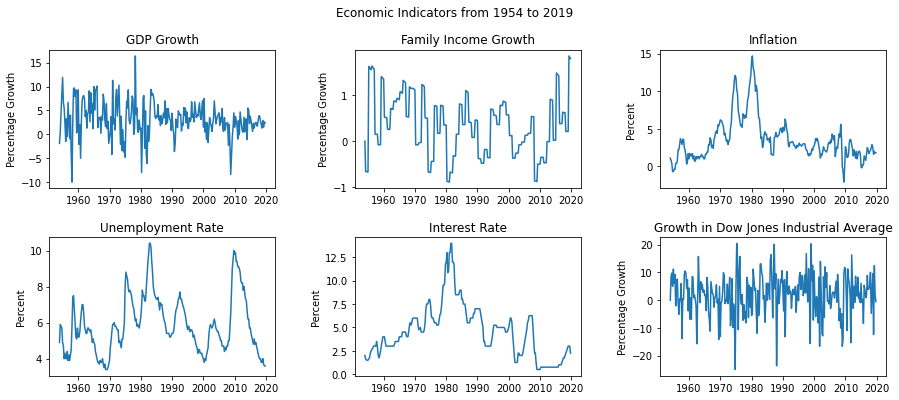

In [326]:
time = data.index
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(15, 6))
ax0.set_title('GDP Growth') 
ax0.plot(time, data['GDP Growth'])
ax0.set_ylabel('Percentage Growth')
ax1.set_title('Family Income Growth') 
ax1.plot(time, data['Real Median Family Income Growth'])
ax1.set_ylabel('Percentage Growth')
ax2.set_title('Inflation') 
ax2.plot(time, data['Inflation Rate'])
ax2.set_ylabel('Percent')
ax3.set_title('Unemployment Rate') 
ax3.plot(time, data['Unemployment Rate'])
ax3.set_ylabel('Percent')
ax4.set_title('Interest Rate') 
ax4.plot(time, data['Interest Rate'])
ax4.set_ylabel('Percent')
ax5.set_title('Growth in Dow Jones Industrial Average') 
ax5.plot(time, data['Dow Growth'])
ax5.set_ylabel('Percentage Growth')
fig.suptitle('Economic Indicators from 1954 to 2019')
fig.subplots_adjust(wspace=.35)
fig.subplots_adjust(hspace=.35)
plt.show()

Interest and Infaltion seem to follow each other, which is reflects that the interest rate is often changed by FED to comabt inflation.  There does seem to be a slight inverse relationship between unemployment and GDP, with where there are peeks in GDP growth there are valleys in the unemployment rate, and vice versa.

Economics data: Blanchard, O. 2021. *Macroeconomics*. Pearson. Print.

Inflation should optimally be around 2%, while GDP growth in the U.S. is typically around 2% in a normal year.

Now doing a comparison of values when GDP Growth was above versus below the typical value of 2%.

In [327]:
aboveGDP = data[data['GDP Growth'] >= 2.0]
aboveGDP

,GDP Growth,Real Median Family Income Growth,Inflation Rate,Unemployment Rate,Interest Rate,Dow Growth
Date,,,,,,
1954-07-01,4.6,-0.66,0.4,5.8,1.50,9.76
1954-10-01,8.1,-0.67,-0.7,5.7,1.50,4.99
1955-01-01,11.9,-0.67,-0.7,4.9,1.50,11.20
1955-04-01,6.7,1.62,-0.4,4.7,1.63,6.16
1955-07-01,5.5,1.60,-0.4,4.0,1.75,9.26
...,...,...,...,...,...,...
2018-04-01,2.7,0.21,2.5,4.0,2.25,-4.75
2018-07-01,2.1,0.21,2.9,3.8,2.50,2.80
2019-01-01,2.9,0.21,1.6,4.0,3.00,-12.40


In [328]:
belowGDP = data[data['GDP Growth'] < 2.0]
belowGDP

,GDP Growth,Real Median Family Income Growth,Inflation Rate,Unemployment Rate,Interest Rate,Dow Growth
Date,,,,,,
1954-01-01,-1.9,0.00,1.1,4.9,2.00,0.00
1954-04-01,0.4,-0.66,0.8,5.9,1.63,8.47
1956-01-01,-1.5,1.55,0.4,4.0,2.50,4.88
1956-07-01,-0.4,1.61,2.2,4.4,2.75,-0.25
1957-04-01,-0.9,0.15,3.7,3.9,3.00,-0.10
...,...,...,...,...,...,...
2015-10-01,0.6,1.44,0.2,5.0,0.75,-8.37
2016-04-01,1.3,0.38,1.1,5.1,1.00,3.75
2017-04-01,1.7,0.63,2.2,4.5,1.50,3.87


In [329]:
def aboveBelowGDP(data0, data1, data2, name):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(15, 6))
    ax0.set_title('All GDP Growth Values') 
    ax0.hist(data0[name])
    ax0.set_ylabel('Frequency')
    ax0.set_xlabel('Percentage Growth')
    ax1.set_title("When GDP Growth Above 2%") 
    ax1.hist(data1[name])
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Percentage Growth')
    ax2.set_title('When GDP Growth Below 2%') 
    ax2.hist(data2[name])
    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Percentage Growth')
    tit = name + ' from 1954 to 2019'
    fig.suptitle(tit)
    fig.subplots_adjust(wspace=.5)
    fig.subplots_adjust(hspace=.35)
    plt.show()
    print("Normality Test for All GDP Growth Values:           ", stats.shapiro(data0[name]))
    print("Normality Test for when GDP Growth Values Above 2%: ", stats.shapiro(data1[name]))
    print("Normality Test for when GDP Growth Values Below 2%: ", stats.shapiro(data2[name]))
    print()
    st, p = stats.mannwhitneyu(data1[name], data2[name])
    print("Mannwhitneyu Test for Differences of Means for Above and Below 2%: ", stats.mannwhitneyu(data1[name], data2[name]))
    print()
    if(p < 0.05):
        print("There is a statistically significant difference between the" , name, "when GDP growth is below 2% versus above 2%.")
        print()
        print("Mean for ", name, "when GDP growth is above 2%: ",  statistics.mean(data1[name]))
        print("Mean for ", name, "when GDP growth is below 2%: ",  statistics.mean(data2[name]))
        print()
        print("The p-value is: ", p)
    else:
        print("There is no statistically significant difference between the " , name, " when GDP growth is below 2% versus above 2%.")

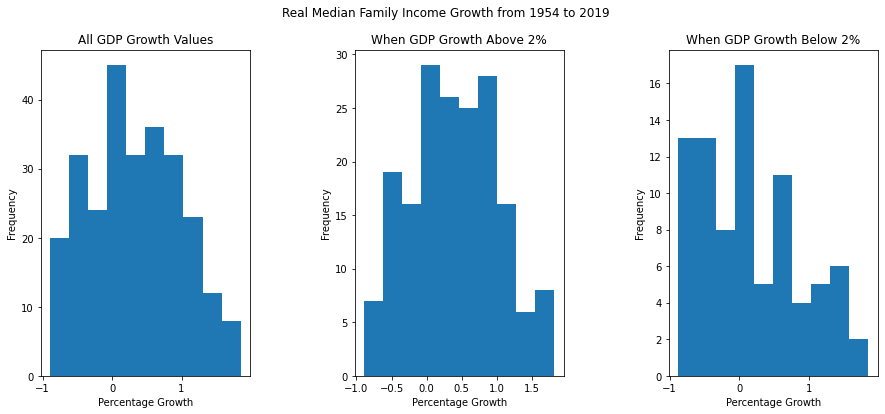

Normality Test for All GDP Growth Values:            ShapiroResult(statistic=0.984096884727478, pvalue=0.004896735772490501)
Normality Test for when GDP Growth Values Above 2%:  ShapiroResult(statistic=0.9892916679382324, pvalue=0.19414077699184418)
Normality Test for when GDP Growth Values Below 2%:  ShapiroResult(statistic=0.9563259482383728, pvalue=0.006205078214406967)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=5845.5, pvalue=0.001505278247514575)

There is a statistically significant difference between the Real Median Family Income Growth when GDP growth is below 2% versus above 2%.

Mean for  Real Median Family Income Growth when GDP growth is above 2%:  0.4055
Mean for  Real Median Family Income Growth when GDP growth is below 2%:  0.16654761904761906

The p-value is:  0.001505278247514575


In [330]:
aboveBelowGDP(data, aboveGDP, belowGDP, 'Real Median Family Income Growth')

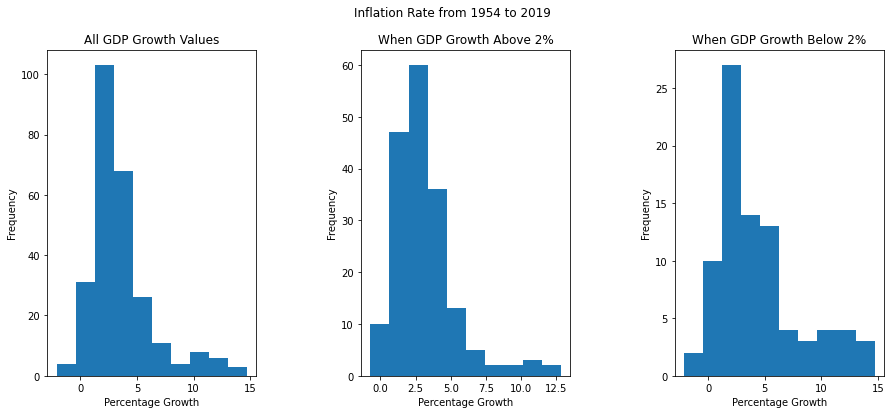

Normality Test for All GDP Growth Values:            ShapiroResult(statistic=0.8593369722366333, pvalue=8.716019002190638e-15)
Normality Test for when GDP Growth Values Above 2%:  ShapiroResult(statistic=0.8688497543334961, pvalue=2.1077977904737644e-11)
Normality Test for when GDP Growth Values Below 2%:  ShapiroResult(statistic=0.9021773338317871, pvalue=9.68646418186836e-06)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=6171.5, pvalue=0.008139656682460613)

There is a statistically significant difference between the Inflation Rate when GDP growth is below 2% versus above 2%.

Mean for  Inflation Rate when GDP growth is above 2%:  3.105
Mean for  Inflation Rate when GDP growth is below 2%:  4.391666666666667

The p-value is:  0.008139656682460613


In [331]:
aboveBelowGDP(data, aboveGDP, belowGDP, 'Inflation Rate')

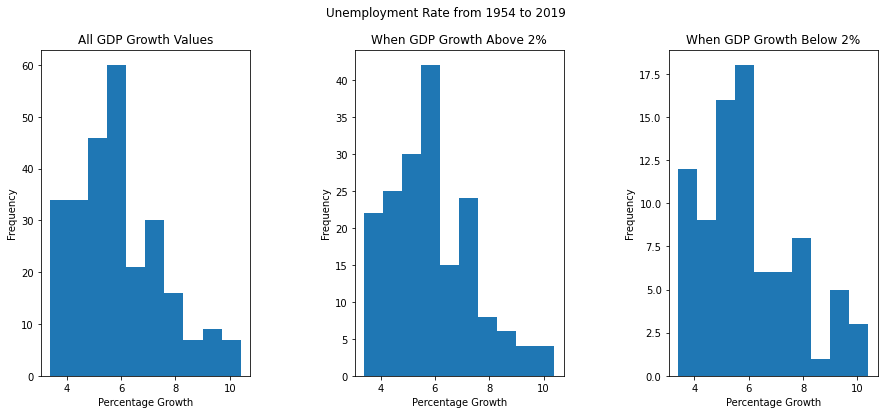

Normality Test for All GDP Growth Values:            ShapiroResult(statistic=0.9500721096992493, pvalue=7.524565859284849e-08)
Normality Test for when GDP Growth Values Above 2%:  ShapiroResult(statistic=0.9527234435081482, pvalue=1.0165661478822585e-05)
Normality Test for when GDP Growth Values Below 2%:  ShapiroResult(statistic=0.9419682621955872, pvalue=0.0008897745283320546)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=7358.0, pvalue=0.36361024454176705)

There is no statistically significant difference between the  Unemployment Rate  when GDP growth is below 2% versus above 2%.


In [332]:
aboveBelowGDP(data, aboveGDP, belowGDP, 'Unemployment Rate')

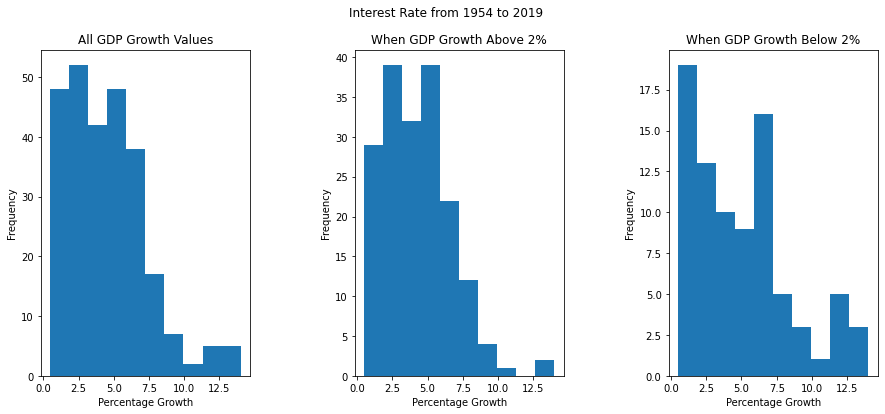

Normality Test for All GDP Growth Values:            ShapiroResult(statistic=0.937071681022644, pvalue=3.4815241800600916e-09)
Normality Test for when GDP Growth Values Above 2%:  ShapiroResult(statistic=0.9515435695648193, pvalue=7.88544366514543e-06)
Normality Test for when GDP Growth Values Below 2%:  ShapiroResult(statistic=0.925287663936615, pvalue=0.00011668116349028423)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=7032.5, pvalue=0.18058620382146134)

There is no statistically significant difference between the  Interest Rate  when GDP growth is below 2% versus above 2%.


In [333]:
aboveBelowGDP(data, aboveGDP, belowGDP, 'Interest Rate')

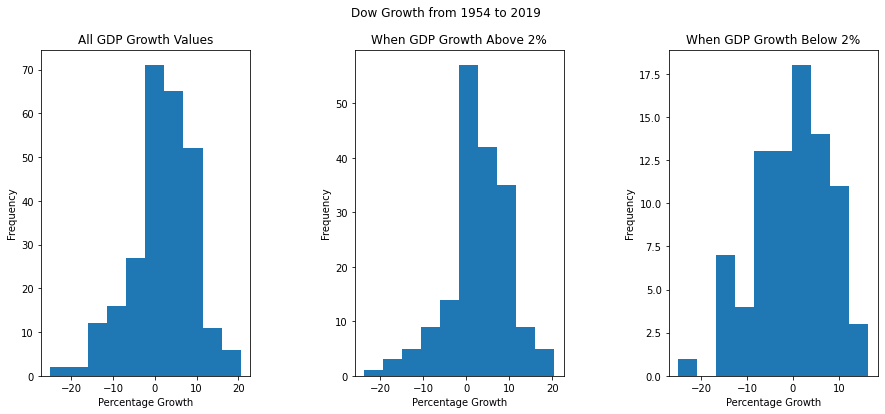

Normality Test for All GDP Growth Values:            ShapiroResult(statistic=0.9779073596000671, pvalue=0.00040418157004751265)
Normality Test for when GDP Growth Values Above 2%:  ShapiroResult(statistic=0.9740656018257141, pvalue=0.0019441909389570355)
Normality Test for when GDP Growth Values Below 2%:  ShapiroResult(statistic=0.9788299202919006, pvalue=0.18162113428115845)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=5868.0, pvalue=0.0017096720817203355)

There is a statistically significant difference between the Dow Growth when GDP growth is below 2% versus above 2%.

Mean for  Dow Growth when GDP growth is above 2%:  3.0455555555555556
Mean for  Dow Growth when GDP growth is below 2%:  -0.2002380952380952

The p-value is:  0.0017096720817203355


In [334]:
aboveBelowGDP(data, aboveGDP, belowGDP, 'Dow Growth')

These seem to not be normally distributed for the most part, so when comparing the means of above and below a GDP level of 2%, the mannwhitneyu test will be used. The function will be updated to do this test as well and print results.  The function is re-run.

Will now do comparison of GDP growth when other values are above/below typical value, listed below:

Median Family Income Growth: 0%

Inflation: 2%

Interest Rate: 2%

Unemployment Rate: 4.5%

Dow Jones Industrial Average Growth: 0%

In [335]:
data

,GDP Growth,Real Median Family Income Growth,Inflation Rate,Unemployment Rate,Interest Rate,Dow Growth
Date,,,,,,
1954-01-01,-1.9,0.00,1.1,4.9,2.00,0.00
1954-04-01,0.4,-0.66,0.8,5.9,1.63,8.47
1954-07-01,4.6,-0.66,0.4,5.8,1.50,9.76
1954-10-01,8.1,-0.67,-0.7,5.7,1.50,4.99
1955-01-01,11.9,-0.67,-0.7,4.9,1.50,11.20
...,...,...,...,...,...,...
2018-10-01,1.3,0.21,2.5,3.8,2.75,9.64
2019-01-01,2.9,0.21,1.6,4.0,3.00,-12.40
2019-04-01,1.5,1.85,2.0,3.7,3.00,12.47


In [336]:
aboveInc = data[data['Real Median Family Income Growth'] >= 0]
belowInc = data[data['Real Median Family Income Growth'] < 0]
aboveInf = data[data['Inflation Rate'] >= 2]
belowInf = data[data['Inflation Rate'] < 2]
aboveUnem = data[data['Unemployment Rate'] >= 4.5]
belowUnem = data[data['Unemployment Rate'] < 4.5]
aboveInt = data[data['Interest Rate'] >= 2]
belowInt = data[data['Interest Rate'] < 2]
aboveDow = data[data['Dow Growth'] >= 0]
belowDow = data[data['Dow Growth'] < 0]

In [337]:
def aboveBelowOther(data0, data1, data2, name, criticalVal):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(15, 6))
    tit1 = 'All ' + name + ' Values' 
    ax0.set_title(tit1) 
    ax0.hist(data0['GDP Growth'])
    ax0.set_ylabel('Frequency')
    ax0.set_xlabel('Percentage Growth')
    tit2 = "When " + name + " Above " + str(criticalVal) + "%"
    ax1.set_title(tit2) 
    ax1.hist(data1['GDP Growth'])
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Percentage Growth')
    tit3 = "When " + name + " Below " + str(criticalVal) + "%"
    ax2.set_title(tit3) 
    ax2.hist(data2['GDP Growth'])
    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Percentage Growth')
    tit = 'GDP Growth from 1954 to 2019'
    fig.suptitle(tit)
    fig.subplots_adjust(wspace=.5)
    fig.subplots_adjust(hspace=.35)
    plt.show()
    stat1 = "Normality Test for when " + name + " Values Above " + str(criticalVal)+ "%: "
    print("Normality Test for All", name, "Values: ", stats.shapiro(data0['GDP Growth']))
    print(stat1, stats.shapiro(data1['GDP Growth']))
    stat2 = "Normality Test for when " + name + " Values Below " + str(criticalVal)+ "%: "
    print(stat2, stats.shapiro(data2['GDP Growth']))
    print()
    st, p = stats.mannwhitneyu(data1['GDP Growth'], data2['GDP Growth'])
    stat1 = "Mannwhitneyu Test for Differences of Means for Above and Below " + str(criticalVal) + "%: "
    print(stat1, stats.mannwhitneyu(data1['GDP Growth'], data2['GDP Growth']))
    print()
    if(p < 0.05):
        stat1 = "There is a statistically significant difference between the GDP Growth when " + name + " is below " + str(criticalVal) + "% versus above " + str(criticalVal) + "%."
        print(stat1)
        print()
        stat2 = "Mean for GDP Growth when " + name + " is above " + str(criticalVal) + "%: "
        print(stat2,  statistics.mean(data1['GDP Growth']))
        stat1 = "Mean for GDP Growth when " + name + " is below " + str(criticalVal) + "%: "
        print(stat1,  statistics.mean(data2['GDP Growth']))
        print()
        print("The p-value is: ", p)
    else:
        stat1 = "There is no statistically significant difference between the GDP Growth when " + name + " is below " + str(criticalVal) + "% versus above " + str(criticalVal) + "%."
        print(stat1)

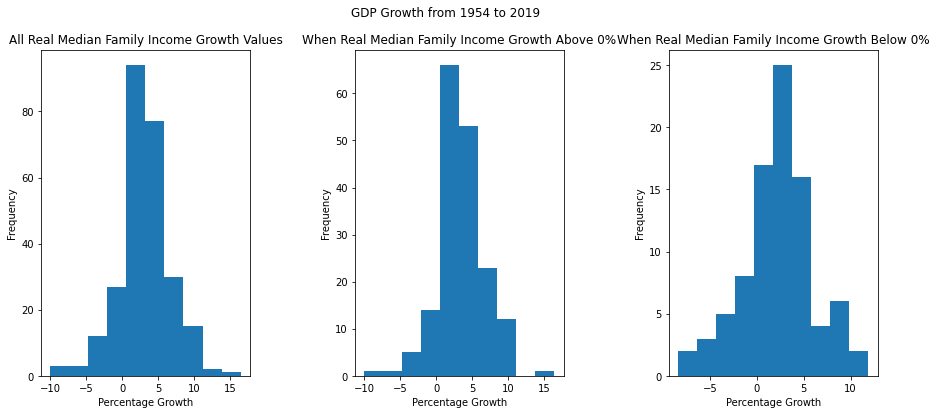

Normality Test for All Real Median Family Income Growth Values:  ShapiroResult(statistic=0.9730337262153625, pvalue=6.810675404267386e-05)
Normality Test for when Real Median Family Income Growth Values Above 0%:  ShapiroResult(statistic=0.9629911780357361, pvalue=0.00013003362982999533)
Normality Test for when Real Median Family Income Growth Values Below 0%:  ShapiroResult(statistic=0.9807108044624329, pvalue=0.21442006528377533)

Mannwhitneyu Test for Differences of Means for Above and Below 0%:  MannwhitneyuResult(statistic=6246.5, pvalue=0.005233148502190048)

There is a statistically significant difference between the GDP Growth when Real Median Family Income Growth is below 0% versus above 0%.

Mean for GDP Growth when Real Median Family Income Growth is above 0%:  3.518181818181818
Mean for GDP Growth when Real Median Family Income Growth is below 0%:  2.268181818181818

The p-value is:  0.005233148502190048


In [338]:
aboveBelowOther(data, aboveInc, belowInc, "Real Median Family Income Growth", 0)

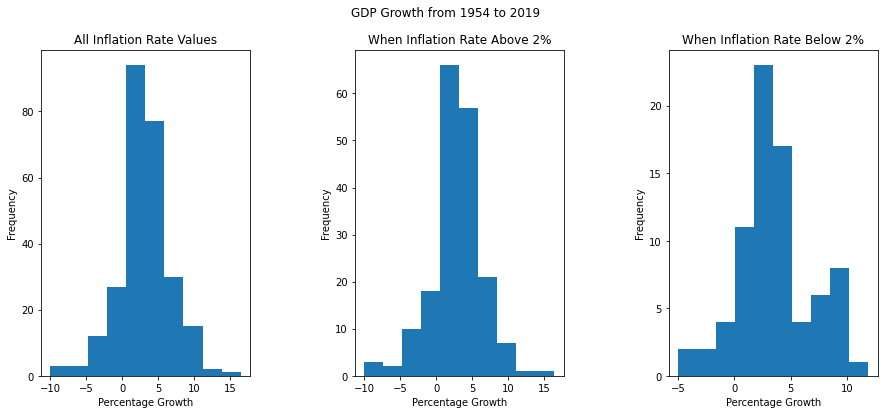

Normality Test for All Inflation Rate Values:  ShapiroResult(statistic=0.9730337262153625, pvalue=6.810675404267386e-05)
Normality Test for when Inflation Rate Values Above 2%:  ShapiroResult(statistic=0.9659811854362488, pvalue=0.0001724025496514514)
Normality Test for when Inflation Rate Values Below 2%:  ShapiroResult(statistic=0.9722169637680054, pvalue=0.08580872416496277)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=6686.0, pvalue=0.15799607859231257)

There is no statistically significant difference between the GDP Growth when Inflation Rate is below 2% versus above 2%.


In [339]:
aboveBelowOther(data, aboveInf, belowInf, "Inflation Rate", 2)

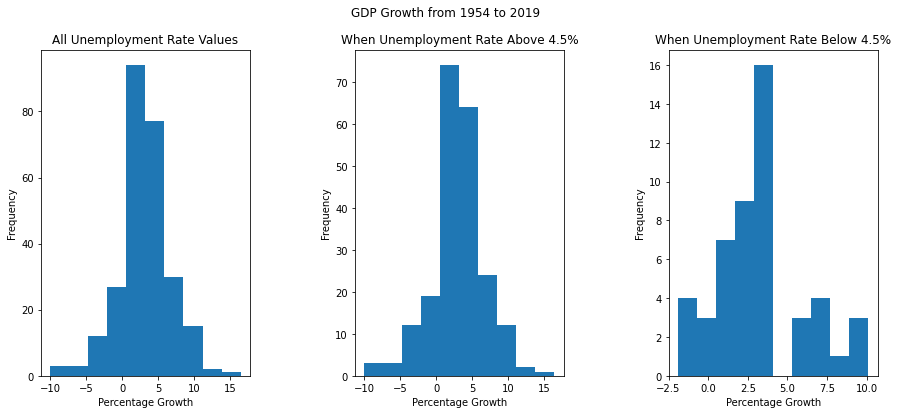

Normality Test for All Unemployment Rate Values:  ShapiroResult(statistic=0.9730337262153625, pvalue=6.810675404267386e-05)
Normality Test for when Unemployment Rate Values Above 4.5%:  ShapiroResult(statistic=0.9732925295829773, pvalue=0.00043779975385405123)
Normality Test for when Unemployment Rate Values Below 4.5%:  ShapiroResult(statistic=0.9497156739234924, pvalue=0.03320995345711708)

Mannwhitneyu Test for Differences of Means for Above and Below 4.5%:  MannwhitneyuResult(statistic=5346.5, pvalue=0.49753760518907336)

There is no statistically significant difference between the GDP Growth when Unemployment Rate is below 4.5% versus above 4.5%.


In [340]:
aboveBelowOther(data, aboveUnem, belowUnem, "Unemployment Rate", 4.5)

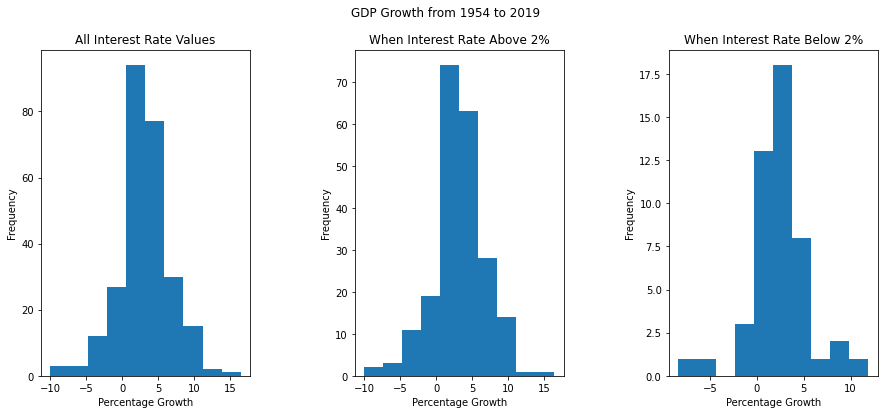

Normality Test for All Interest Rate Values:  ShapiroResult(statistic=0.9730337262153625, pvalue=6.810675404267386e-05)
Normality Test for when Interest Rate Values Above 2%:  ShapiroResult(statistic=0.9768486022949219, pvalue=0.0012722201645374298)
Normality Test for when Interest Rate Values Below 2%:  ShapiroResult(statistic=0.9203716516494751, pvalue=0.003063902724534273)

Mannwhitneyu Test for Differences of Means for Above and Below 2%:  MannwhitneyuResult(statistic=4365.5, pvalue=0.04365816464748961)

There is a statistically significant difference between the GDP Growth when Interest Rate is below 2% versus above 2%.

Mean for GDP Growth when Interest Rate is above 2%:  3.234259259259259
Mean for GDP Growth when Interest Rate is below 2%:  2.5041666666666664

The p-value is:  0.04365816464748961


In [341]:
aboveBelowOther(data, aboveInt, belowInt, "Interest Rate", 2)

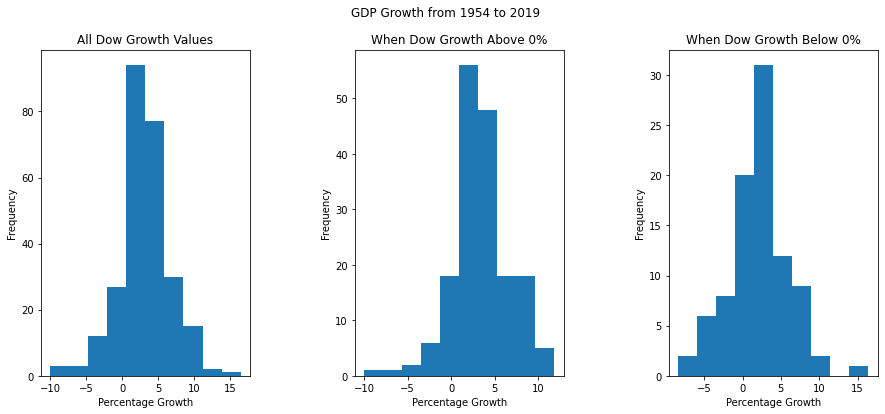

Normality Test for All Dow Growth Values:  ShapiroResult(statistic=0.9730337262153625, pvalue=6.810675404267386e-05)
Normality Test for when Dow Growth Values Above 0%:  ShapiroResult(statistic=0.9638857841491699, pvalue=0.00018607490346767008)
Normality Test for when Dow Growth Values Below 0%:  ShapiroResult(statistic=0.9715654850006104, pvalue=0.043606001883745193)

Mannwhitneyu Test for Differences of Means for Above and Below 0%:  MannwhitneyuResult(statistic=6242.0, pvalue=0.002862663613383836)

There is a statistically significant difference between the GDP Growth when Dow Growth is below 0% versus above 0%.

Mean for GDP Growth when Dow Growth is above 0%:  3.5445086705202313
Mean for GDP Growth when Dow Growth is below 0%:  2.2593406593406593

The p-value is:  0.002862663613383836


In [342]:
aboveBelowOther(data, aboveDow, belowDow, "Dow Growth", 0)

Now will try to do regressions for each economic indicator with GDP Growth:

In [343]:
data

,GDP Growth,Real Median Family Income Growth,Inflation Rate,Unemployment Rate,Interest Rate,Dow Growth
Date,,,,,,
1954-01-01,-1.9,0.00,1.1,4.9,2.00,0.00
1954-04-01,0.4,-0.66,0.8,5.9,1.63,8.47
1954-07-01,4.6,-0.66,0.4,5.8,1.50,9.76
1954-10-01,8.1,-0.67,-0.7,5.7,1.50,4.99
1955-01-01,11.9,-0.67,-0.7,4.9,1.50,11.20
...,...,...,...,...,...,...
2018-10-01,1.3,0.21,2.5,3.8,2.75,9.64
2019-01-01,2.9,0.21,1.6,4.0,3.00,-12.40
2019-04-01,1.5,1.85,2.0,3.7,3.00,12.47


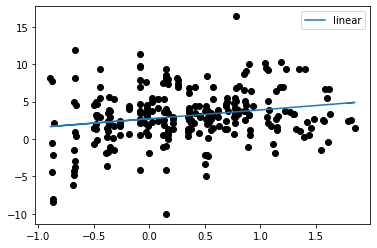

In [344]:
import numpy as np
import sklearn 
from sklearn.linear_model import LinearRegression
x=data['Real Median Family Income Growth']
y=data['GDP Growth']
plt.scatter(x, y, color="black")
model_linear=LinearRegression(fit_intercept=True)
model_linear.fit(np.vstack([x]).T, y)
yf_linear=model_linear.predict(np.vstack([x]).T)
plt.plot(x,yf_linear, label="linear")
plt.legend()
plt.show()

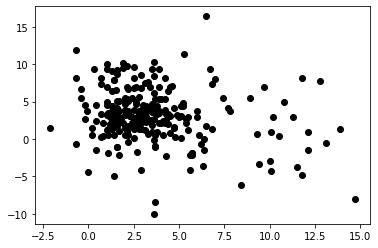

In [345]:
x = data['Inflation Rate']
plt.scatter(x, y, color="black")
plt.show()

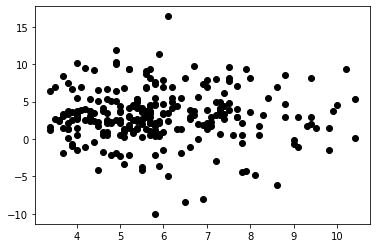

In [346]:
x = data['Unemployment Rate']
plt.scatter(x, y, color="black")
plt.show()

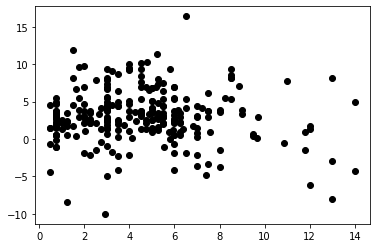

In [347]:
x = data['Interest Rate']
plt.scatter(x, y, color="black")
plt.show()

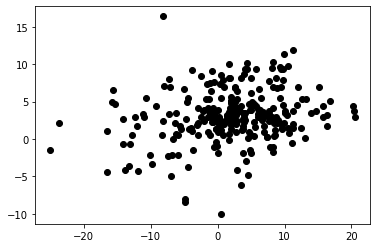

In [348]:
x = data['Dow Growth']
plt.scatter(x, y, color="black")
plt.show()

From the above, it seems that it would be a waste to try to do a regression for GDP, as there are no clear polynomial relationships between these quantities and GDP.  I thought of doing clustering, but it seems like there is really only one cluster for each scatter plot, so I do not think I would gain much from that. Might be able to do regression with other values though:

In [349]:
data

,GDP Growth,Real Median Family Income Growth,Inflation Rate,Unemployment Rate,Interest Rate,Dow Growth
Date,,,,,,
1954-01-01,-1.9,0.00,1.1,4.9,2.00,0.00
1954-04-01,0.4,-0.66,0.8,5.9,1.63,8.47
1954-07-01,4.6,-0.66,0.4,5.8,1.50,9.76
1954-10-01,8.1,-0.67,-0.7,5.7,1.50,4.99
1955-01-01,11.9,-0.67,-0.7,4.9,1.50,11.20
...,...,...,...,...,...,...
2018-10-01,1.3,0.21,2.5,3.8,2.75,9.64
2019-01-01,2.9,0.21,1.6,4.0,3.00,-12.40
2019-04-01,1.5,1.85,2.0,3.7,3.00,12.47


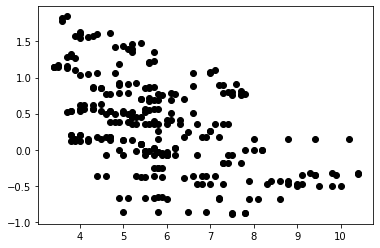

In [350]:
x = data['Unemployment Rate']
y = data['Real Median Family Income Growth']
plt.scatter(x, y, color="black")
plt.show()

Potential

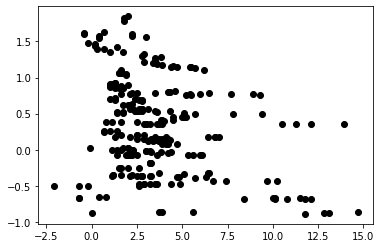

In [351]:
x = data['Inflation Rate']
y = data['Real Median Family Income Growth']
plt.scatter(x, y, color="black")
plt.show()

Potential, maybe Quadratic

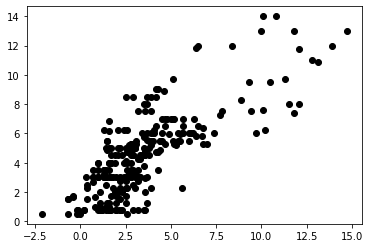

In [352]:
x = data['Inflation Rate']
y = data['Interest Rate']
plt.scatter(x, y, color="black")
plt.show()

Definetely can find a regression

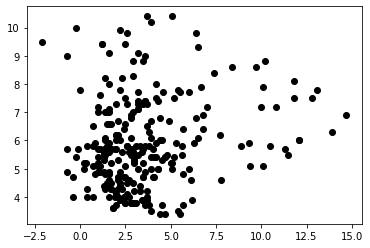

In [353]:
x = data['Inflation Rate']
y = data['Unemployment Rate']
plt.scatter(x, y, color="black")
plt.show()

Maybe?

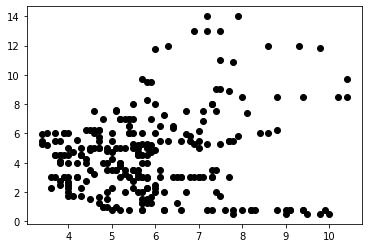

In [354]:
x = data['Unemployment Rate']
y = data['Interest Rate']
plt.scatter(x, y, color="black")
plt.show()

Somewhat

Writing a function that will find the strength of the correlation, use spearman because they are not normal. The best fit will be found among a linear, quadratic, and cubic polynomial. 

In [355]:
def correlateAndFit(data0, name1, name2):
    cor, p = stats.spearmanr(data0[name1], data0[name2])
    print("The p-value of the spearmanr test for ", name1, "and", name2, "was", p)
    print("The correlation coefficient for ", name1, "and", name2, "was", cor)
    print()
    print()
    x=data0[name1]
    y=data0[name2]
    plt.scatter(x, y, color="black")
    plt.xlabel(name1)
    plt.ylabel(name2)
    tit = name1 + " and " + name2 + " from 1954 to 2019"
    plt.title(tit)
    model_linear=LinearRegression(fit_intercept=True)
    model_squared=LinearRegression(fit_intercept=True)
    model_cubic=LinearRegression(fit_intercept=True)
    x2=x**2
    x3=x**3
    model_linear.fit(np.vstack([x]).T, y)
    model_squared.fit(np.vstack([x,x2]).T, y)
    model_cubic.fit(np.vstack([x,x2,x3]).T, y)
    yf_linear=model_linear.predict(np.vstack([x]).T)
    yf_squared=model_squared.predict(np.vstack([x,x2]).T)
    yf_cubic=model_cubic.predict(np.vstack([x,x2,x3]).T)
    plt.plot(x,yf_linear, label="Linear")
    plt.plot(x,yf_squared, label="Quadratic")
    plt.plot(x,yf_cubic, label="Cubic")
    linr = model_linear.score(np.vstack([x]).T, y)
    quadr = model_squared.score(np.vstack([x,x2]).T, y)
    cubr = model_cubic.score(np.vstack([x,x2,x3]).T, y)
    plt.legend()
    plt.show()
    print()
    coef = "The Coefficients of Determination were:\nLinear: " + str(linr) + "\nQuadratic: " + str(quadr) + "\nCubic: " + str(cubr) 
    print(coef)
    print()
    print()
    lin = "Linear Model Coefficients and Intercept:\nIntercept: " + str(model_linear.intercept_) + "\nCoefficients: " + str(model_linear.coef_)
    print(lin)
    print()
    quad = "Quadratic Model Coefficients and Intercept:\nIntercept: " + str(model_squared.intercept_) + "\nCoefficients: " + str(model_squared.coef_)
    print(quad)
    print()
    quad = "Cubic Model Coefficients and Intercept:\nIntercept: " + str(model_cubic.intercept_) + "\nCoefficients: " + str(model_cubic.coef_)
    print(quad)

The p-value of the spearmanr test for  Unemployment Rate and Real Median Family Income Growth was 4.9113464320525075e-20
The correlation coefficient for  Unemployment Rate and Real Median Family Income Growth was -0.5241823744764901




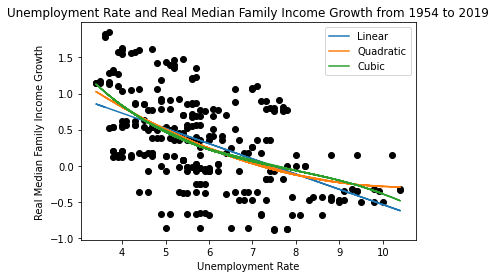


The Coefficients of Determination were:
Linear: 0.27407927558413425
Quadratic: 0.2896547338138874
Cubic: 0.2937506557851657


Linear Model Coefficients and Intercept:
Intercept: 1.5739196692335897
Coefficients: [-0.21130357]

Quadratic Model Coefficients and Intercept:
Intercept: 2.5876077398491293
Coefficients: [-0.54733652  0.02597037]

Cubic Model Coefficients and Intercept:
Intercept: 4.402444701053764
Coefficients: [-1.45803319  0.17042995 -0.00725298]


In [356]:
correlateAndFit(data, 'Unemployment Rate', 'Real Median Family Income Growth')

The p-value of the spearmanr test for  Inflation Rate and Real Median Family Income Growth was 1.8931036170096276e-06
The correlation coefficient for  Inflation Rate and Real Median Family Income Growth was -0.28835162858681074




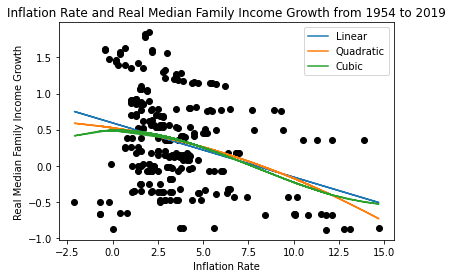


The Coefficients of Determination were:
Linear: 0.11048348103319405
Quadratic: 0.11445008455834016
Cubic: 0.11637757853602426


Linear Model Coefficients and Intercept:
Intercept: 0.5934884853453171
Coefficients: [-0.07512498]

Quadratic Model Coefficients and Intercept:
Intercept: 0.5260566477290151
Coefficients: [-0.03665214 -0.00334224]

Cubic Model Coefficients and Intercept:
Intercept: 0.49047328559094033
Coefficients: [ 0.00536222 -0.01339957  0.00056532]


In [357]:
correlateAndFit(data, 'Inflation Rate', 'Real Median Family Income Growth')

The p-value of the spearmanr test for  Inflation Rate and Interest Rate was 6.256340874590819e-47
The correlation coefficient for  Inflation Rate and Interest Rate was 0.7394579968391961




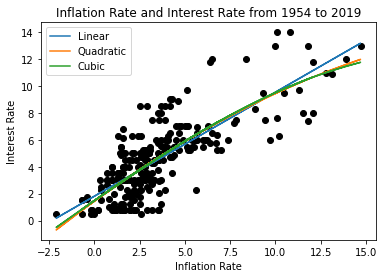


The Coefficients of Determination were:
Linear: 0.5989724266187064
Quadratic: 0.6047982497039779
Cubic: 0.6049089302844118


Linear Model Coefficients and Intercept:
Intercept: 1.800605068016087
Coefficients: [0.77432665]

Quadratic Model Coefficients and Intercept:
Intercept: 1.438846091994793
Coefficients: [ 0.98072611 -0.01793049]

Cubic Model Coefficients and Intercept:
Intercept: 1.476592119413814
Coefficients: [ 9.36158212e-01 -7.26191058e-03 -5.99677867e-04]


In [358]:
correlateAndFit(data, 'Inflation Rate', 'Interest Rate')

The p-value of the spearmanr test for  Inflation Rate and Unemployment Rate was 0.010247491425771669
The correlation coefficient for  Inflation Rate and Unemployment Rate was 0.1577681852720261




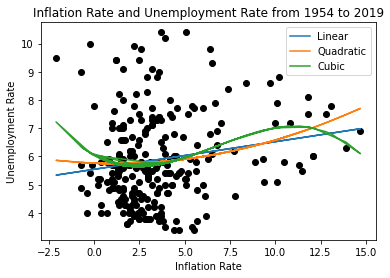


The Coefficients of Determination were:
Linear: 0.030517479910462164
Quadratic: 0.03717657307436417
Cubic: 0.05648553764222353


Linear Model Coefficients and Intercept:
Intercept: 5.545605115433221
Coefficients: [0.09782308]

Quadratic Model Coefficients and Intercept:
Intercept: 5.762073464684712
Coefficients: [-0.02568167  0.0107292 ]

Cubic Model Coefficients and Intercept:
Intercept: 6.04111009587291
Coefficients: [-0.35514879  0.08959645 -0.0044331 ]


In [359]:
correlateAndFit(data, 'Inflation Rate', 'Unemployment Rate')

The p-value of the spearmanr test for  Unemployment Rate and Interest Rate was 0.49829971575531895
The correlation coefficient for  Unemployment Rate and Interest Rate was 0.041857126411775906




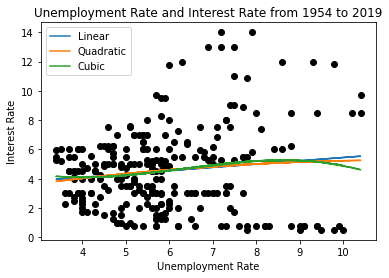


The Coefficients of Determination were:
Linear: 0.015802315515630716
Quadratic: 0.016407368861470206
Cubic: 0.01875450792382727


Linear Model Coefficients and Intercept:
Intercept: 3.199122591259041
Coefficients: [0.22460229]

Quadratic Model Coefficients and Intercept:
Intercept: 2.314687787760615
Coefficients: [ 0.51778837 -0.02265894]

Cubic Model Coefficients and Intercept:
Intercept: 8.39626549526026
Coefficients: [-2.53398582  0.46142981 -0.02430499]


In [360]:
correlateAndFit(data, 'Unemployment Rate', 'Interest Rate')

Insignificant